In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [13]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9			#number of inside corners in row
ny = 6			#number of inside corners in col

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
#print(objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    #grayscale all images
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# you should now have objpoints and imgpoints needed for camera calibration. 
# Do camera calibration given object points and image points
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# # Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal_pickle.p", "wb" ))

The undistort function with respect to our camera calibration has been defined in the cell below

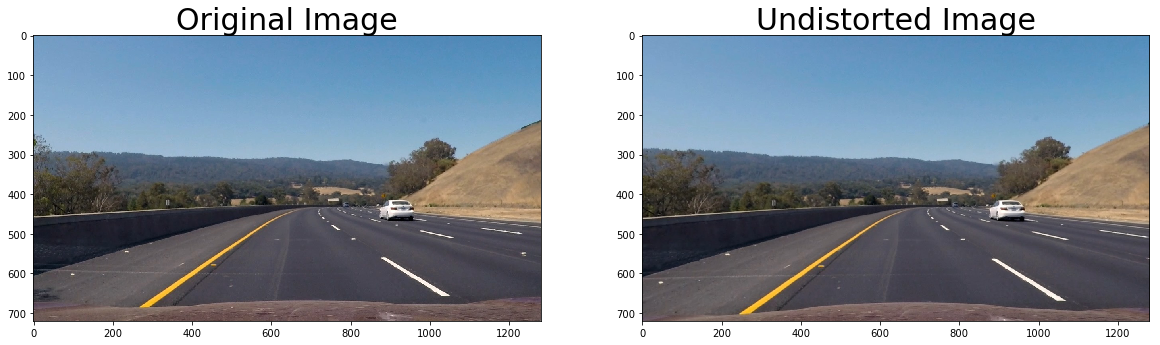

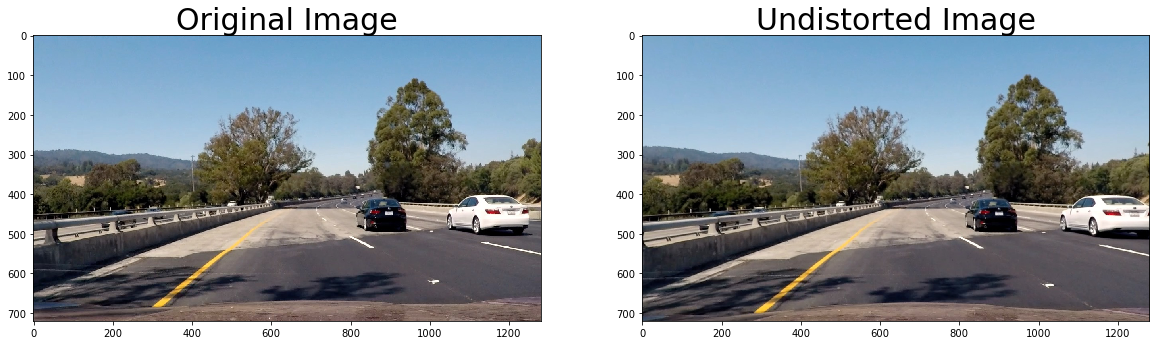

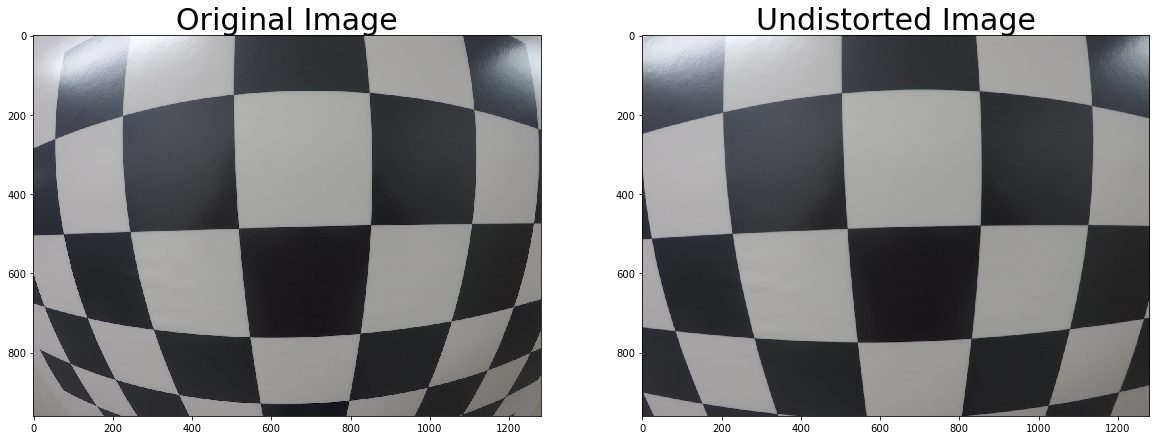

In [42]:
def undist(img , show_output=0, save_output=0 ):
    # Test undistortion on a given image
    img_size = (img.shape[1], img.shape[0])
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    if save_output!=0:
        dst1 = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        cv2.imwrite('output_images/'+save_output ,dst1)
    
    # Visualize undistortion
    if show_output==1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
    return dst
    
images = glob.glob('test_images/test*.jpg')
for x ,fname in enumerate(images):
    img = mpimg.imread(fname)
    y = undist(img , x//2 , fname[12:-4]+"_undist.jpg")

img = mpimg.imread("camera_cal/test_image.jpg")
img_0 = undist( img, 1)

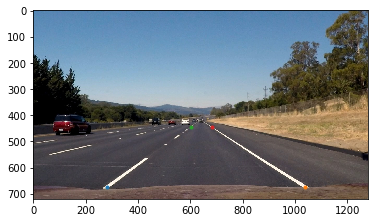

In [53]:
set_per = mpimg.imread('./test_images/straight_lines2.jpg')
plt.imshow(set_per)
plt.plot(281,674,'.')
plt.plot(1040,674,'.')
plt.plot(601,446,'.')
plt.plot(683,446,'.')

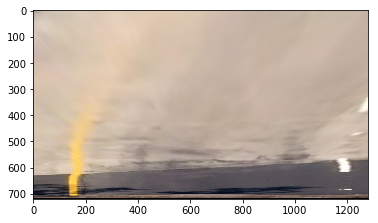

In [61]:
def perspective_transform(img, M):
    warped = cv2.warpPerspective(img, M, (img.shape[1] , img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped

# src = np.float32([[297,663] , [1023,663] , [683,446] , [601,446] ])
# dst = np.float32([[100,700] , [1100,700] , [1100,100] , [100,100]])   #a desired rectangle
# M   = cv2.getPerspectiveTransform(src , dst)   

to_warp_loc = "./test_images/test4.jpg"
to_warp = mpimg.imread(to_warp_loc)
warp_img = perspective_transform(to_warp  , M)
plt.imshow(warp_img)

In [36]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output